In [11]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from glob import glob
import random

5000
/common/users/dm1487/inhand_manipulation_data_store/datastore_41/6/2023-10-29_00-07-32.npz
206


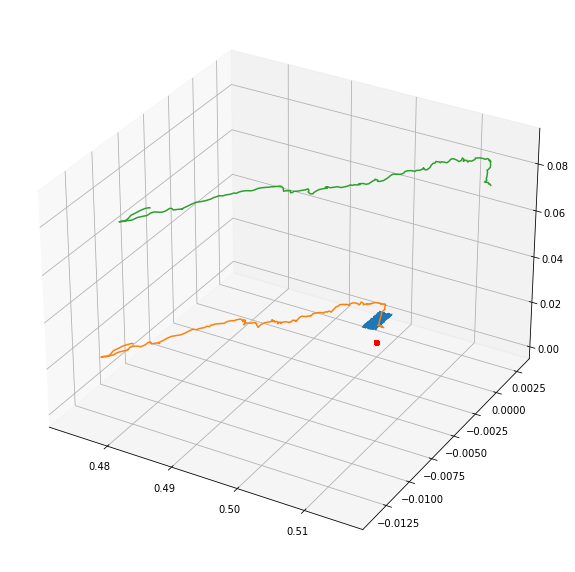

In [19]:
all_paths = glob('/common/users/dm1487/inhand_manipulation_data_store/datastore_41/*/*.npz')
print(len(all_paths))
path = random.sample(all_paths, 1)[0]
data = np.load(path)
# path = random.sample(all_paths, 1)[0]
print(path)
done_idx = data['done'].nonzero()[-1][0]
print(done_idx)
ax = plt.figure(figsize=(10, 20)).add_subplot(projection='3d')
ax.scatter(data['socket_pos'][:done_idx, 0], data['socket_pos'][:done_idx, 1], zs=data['socket_pos'][:done_idx, 2], color='r')
ax.plot(data['noisy_socket_pos'][:done_idx, 0], data['noisy_socket_pos'][:done_idx, 1], zs=data['noisy_socket_pos'][:done_idx, 2])
ax.plot(data['plug_pos'][:done_idx, 0], data['plug_pos'][:done_idx, 1], zs=data['plug_pos'][:done_idx, 2])
ax.plot(data['eef_pos'][:done_idx, 0], data['eef_pos'][:done_idx, 1], zs=data['eef_pos'][:done_idx, 2])

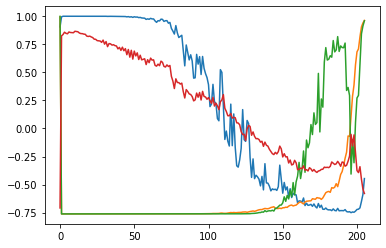

In [20]:
latent = data['latent']
plt.plot(latent[:done_idx, :])

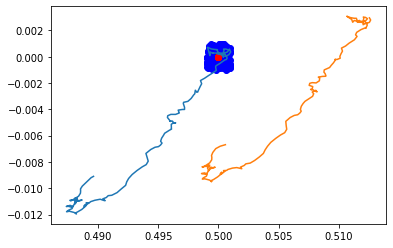

In [14]:
plt.scatter(data['noisy_socket_pos'][1:done_idx, 0], data['noisy_socket_pos'][1:done_idx, 1], color='b')
plt.plot(data['plug_pos'][1:done_idx, 0], data['plug_pos'][1:done_idx, 1])
plt.plot(data['eef_pos'][1:done_idx, 0], data['eef_pos'][1:done_idx, 1])
plt.scatter(data['socket_pos'][1:done_idx, 0], data['socket_pos'][1:done_idx, 1], color='r', s=35)


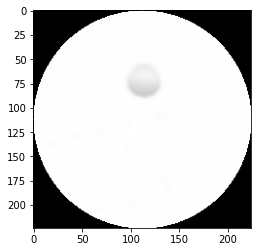

In [15]:
plt.imshow(data['tactile'][40][2][:], cmap='gray')

In [16]:
import cv2
import numpy as np
from tqdm import tqdm

# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
video = cv2.VideoWriter('video.avi', fourcc, 20, (672, 224), isColor=False)


for j in tqdm(range(0,done_idx)):
    tactile_img = data['tactile']
    img1 = tactile_img[j][0]
    img2 = tactile_img[j][1]
    img3 = tactile_img[j][2]
    img = np.concatenate([img1, img2, img3], axis=1)
    video.write((img*255).astype(np.uint8))
cv2.destroyAllWindows()
video.release()

# video2 = cv2.VideoWriter('video2.avi', fourcc, 20, (224, 224), isColor=False)
# for j in tqdm(range(0,done_idx)):
#   img2 = data['tactile'][j][1]
#   video2.write((img2*255).astype(np.uint8))
# cv2.destroyAllWindows()
# video2.release()

# video3 = cv2.VideoWriter('video3.avi', fourcc, 20, (224, 224), isColor=False)
# for j in tqdm(range(0,done_idx)):
#   img3 = data['tactile'][j][2]
#   video3.write((img3*255).astype(np.uint8))
# cv2.destroyAllWindows()
# video3.release()

100%|█████████████████████████████████████████████████████████████████████████| 179/179 [01:14<00:00,  2.42it/s]


In [142]:
data['latent'].max()

1.0

In [143]:
from tqdm import tqdm
import os
maxs, mins, means = [], [], []
for i in tqdm(random.sample(all_paths, 50)):
    dat = np.load(i)
    done_idx = dat['done'].nonzero()[-1][0]
    if done_idx == 0:
        print(i)
        os.remove(i)
        continue
    arm_joints = dat["arm_joints"]
    eef_pos = dat["eef_pos"]
    noisy_socket_pos = dat["noisy_socket_pos"]
    action = dat["action"]
    target = dat["target"]
    latent = dat["latent"]
    means.append(noisy_socket_pos[:done_idx].mean(axis=0))
    
    # action = (dat['action'] - np.array([0.13031891, -0.06950727, -0.19852978,  0.0347245 ,  0.23399816,
    #     -0.7549616])) /np.array([0.32046735, 0.31363848, 0.1424867 , 0.19202784, 0.13758121,
    #     0.15014388])

    # target = (dat['target'] - np.array([0.10709909, -0.01316157, -0.02943857, -0.00528099,  0.02366312,
    #     -0.07168248])) /np.array([0.17599952, 0.16872492, 0.07339223, 0.02205627, 0.01348054,
    #     0.04105581])

    # arm_joints = (dat['arm_joints'] - np.array([0.01588645,  0.36629117, -0.02190276, -1.745692  ,  0.01016568,
    #      1.0313178 , -1.5791312])) /np.array([0.00594231, 0.01003645, 0.00602225, 0.01345219, 0.00340213,
    #     0.01449401, 0.00991344])

    # eef_pos = (dat['eef_pos'] - np.array([5.0263488e-01, -5.6965562e-04,  1.8021877e-01, -7.0660496e-01,
    #      7.0756161e-01,  8.9282764e-04, -3.5167387e-04])) /np.array([0.00456982, 0.00380174, 0.00208658, 0.00207865, 0.00208563,
    #     0.00330151, 0.00407403])

    
    # mins.append(dat['action'][:done_idx].min(axis=-1))
    # maxs.append(dat['action'][:done_idx].max(axis=-1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 105.67it/s]


In [144]:
maxs = np.array(maxs)
mins = np.array(mins)
means = np.array(means)

In [145]:
np.array(means).mean(axis=0), np.array(means).std(axis=0) # , np.array(mins).min(axis=0)

(array([ 5.0000381e-01, -5.3307658e-06,  1.1000000e-02, -1.1920929e-07,
        -1.0000000e+00, -8.7422713e-08, -1.0000000e+00,  5.9604641e-08,
         3.5527137e-15,  3.5527137e-15,  8.7422713e-08, -1.0000000e+00],
       dtype=float32),
 array([5.2943244e-05, 4.6623343e-05, 1.0455730e-08, 0.0000000e+00,
        0.0000000e+00, 1.1809126e-13, 0.0000000e+00, 1.9459015e-15,
        0.0000000e+00, 0.0000000e+00, 1.1809126e-13, 0.0000000e+00],
       dtype=float32))

In [146]:
np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3515406556.py:1: RuntimeWarning: Mean of empty slice.
  np.array(mins).mean(axis=0), np.array(mins).std(axis=0) # , np.array(mins).min(axis=0)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/common/users/dm1487/envs/inhand_py38/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

In [184]:
np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)

/tmp/ipykernel_3055377/3689302195.py:1: RuntimeWarning: Mean of empty slice.
  np.array(maxs).mean(axis=0), np.array(maxs).std(axis=0) # , np.array(mins).min(axis=0)


(nan, nan)

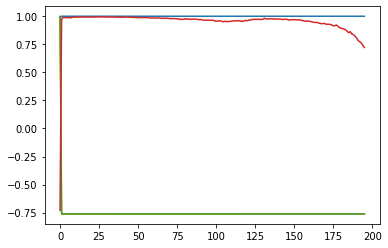

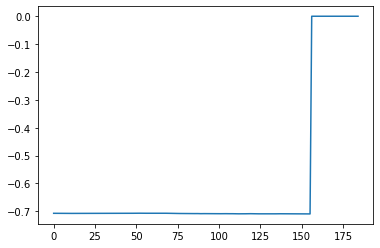

In [208]:
plt.plot(data['eef_pos'][:done_idx, 3])

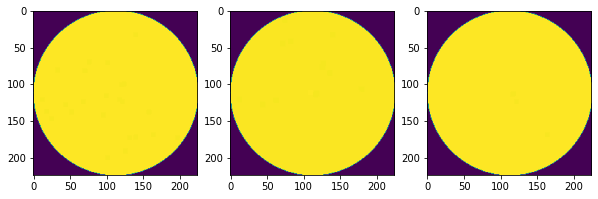

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(10, 30))
t = 0

# (dat['tactile'][t][0]).min()


ax[0].imshow(dat['tactile'][t][0])
ax[1].imshow(dat['tactile'][t][1])
ax[2].imshow(dat['tactile'][t][2])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [02:06<00:00,  2.31it/s]


In [239]:
def denormalize_image(image, min_value, max_value):
    denormalized_image = (image + 1) * 0.5 # * (max_value - min_value) + min_value
    return denormalized_image

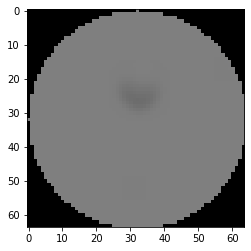

In [80]:
plt.imshow(denormalize_image(data['tactile_img'][0][150, 0], 0, 1))

In [1]:
import torch
import time

In [36]:
a = torch.randn(1250000, 1000)

In [43]:
st = time.time()
a = a.to('cuda:0')
time.time() - st

6.580352783203125e-05